In [1]:
from __future__ import division

import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt

from os.path import join
import os

import torch
import torchvision.utils as vutils
from scipy.io import loadmat, savemat
import numpy as np
import argparse
from torch.autograd import Variable

from loaders import locations, getLoaders
from models import getModels
from scipy.stats import kendalltau # distance metrics between permutations


def extractPercentileStats(trainProbs, testProbs):
    sortedInds = np.argsort(np.concatenate([trainProbs, testProbs]))
    trainTest = np.concatenate([np.ones(len(trainProbs), dtype='int'),np.zeros(len(testProbs),dtype='int')])
    trainTest = trainTest[sortedInds]
    cumulative = np.cumsum(trainTest)
    testPercentiles = cumulative[trainTest==0]/float(len(trainProbs))
    return testPercentiles

def heatmapFlowgan(net, codesOnly=False, savePrefix='fig'):
    if not os.path.isdir(savePrefix):
        print "Making dir"
        os.makedirs(savePrefix)
    grid0, grid1 = np.meshgrid(np.linspace(-1.5,1.5,100),np.linspace(1.5,-1.5,100))
    print grid0.shape, grid1.shape
    pts = np.zeros((10000,2))
    for i in range(100):
        for j in range(100):
            pts[i*100+j,:] = grid0[i,j],grid1[i,j]
    ptsTorch = Variable(torch.from_numpy(pts.astype(np.float32)))
    vals, logp = net.invert(ptsTorch)
    
    if codesOnly:
        vals = vals.data.numpy()
        logpcodes = -0.5*np.sum(vals*vals,1)
        logpcodes = logpcodes.squeeze()
    #    if compareProbs:
        logpmodel = logp.data.numpy().squeeze()
        jacob = logpmodel-logpcodes
        print jacob.min(), jacob.max(), jacob.mean()
        plt.figure()
        plt.hist(jacob)
        plt.savefig(join(savePrefix,'histogram_jacobian.pdf'), dpi=500)
        
        plt.figure()
        plt.hist(logpcodes[logpcodes>-100])
        plt.savefig(join(savePrefix,'histogram_largest_codes.pdf'), dpi=500)
        
        inds1 = np.argsort(logpcodes)
        inds2 = np.argsort(logpmodel)
        print np.sum(inds1==inds2)
        print kendalltau(inds1, inds2)
            
        sortedModel = logpmodel[inds1]
        plt.figure()
        plt.plot(sortedModel[sortedModel>-10], '.')
        plt.savefig(join(savePrefix,'logprobs_cross_sorted.pdf'), dpi=500)
            
        probsNumpyCodes = logpcodes.reshape((100,100))
        
              #  print probsNumpy[:5,:5]
        transformedCodes = np.exp(probsNumpyCodes)
           # transformed = probsNumpy[probsNumpy<probsNumpy.mean()]=probsNumpy.mean()
        plt.figure()
        plt.imshow(transformedCodes, extent=[-1.5,1.5,-1.5,1.5])
       # plt.ylim(-1.5, 1.5)
       # plt.xlim(-1.5, 1.5)
        plt.savefig(join(savePrefix,'heatmap_codes_only.png'), dpi=500)
        
        probsNumpy = logpmodel.reshape((100,100))
        transformed = np.exp(probsNumpy)
        plt.figure()
        plt.imshow(transformed, extent=[-1.5,1.5,-1.5,1.5])
        plt.savefig(join(savePrefix,'heatmap.png'), dpi=500)

            
    else:
        probsNumpy = logp.data.numpy().reshape((100,100))
        
          #  print probsNumpy[:5,:5]
        transformed = np.exp(probsNumpy)
           # transformed = probsNumpy[probsNumpy<probsNumpy.mean()]=probsNumpy.mean()
        plt.figure()
        plt.imshow(transformed, extent=[-1.5,1.5,-1.5,1.5])
        plt.savefig(join(savePrefix,'heatmap.png'), dpi=500)
    
def plotMogSamplesFlowgan(netG, npts, savePrefix='fig'):
    if not os.path.isdir(savePrefix):
        print "Making dir"
        os.makedirs(savePrefix)
    samples = np.random.normal(0,1,(npts,2)).astype(np.float32)
    samples = Variable(torch.from_numpy(samples))
    pts, _ = netG(samples)
    pts = pts.data.numpy()
    plt.figure()
    plt.plot(pts[:,0], pts[:,1], '.')
    plt.savefig(join(savePrefix,'flowgan_samples.pdf'), dpi=200, bbox_inches='tight')
    
def plotMogSamples(netG, npts):
    samples = np.random.normal(0,1,(npts,2)).astype(np.float32)
    samples = Variable(torch.from_numpy(samples))
    pts = netG(samples).data.numpy()
    plt.plot(pts[:,0], pts[:,1], '.')
    
def sortPlot(codeProbs, probs):
    inds = np.argsort(codeProbs)
    plt.figure()
    plt.plot(probs[inds], '.')
   
def hiLowFlip(pdict, number=36, imageArray=None, nrow=6, resolution=5, classes=None, useCodeProbs=False, savePrefix='fig'):
    if not os.path.isdir(savePrefix):
        print "Making dir"
        os.makedirs(savePrefix)
    
    if imageArray is None:
        ims = pdict['images']
    else:
        ims = imageArray
        
    if useCodeProbs:
        probs = pdict['codeProbs'].squeeze()
    else:
        probs = pdict['probs'].squeeze()
    
    
    if classes is not None:
        unique = np.unique(classes)
        for v in unique:
            inds = np.argsort(probs[classes==v])
            imsRestricted = ims[classes==v]
            
            classInds = np.where((classes==v)[inds])[0]
           # print classes[classInds]
            imsTop = torch.from_numpy(imsRestricted[inds[-number:]])
            imsBot = torch.from_numpy(imsRestricted[inds[:number]])
            topGrid = vutils.make_grid(imsTop, nrow=nrow, normalize=True)
            botGrid = vutils.make_grid(imsBot, nrow=nrow, normalize=True)
            print "Class", v
            plt.figure(figsize=(5,5))
            plt.axis('off')
            plt.imshow(np.flipud(np.fliplr(topGrid.numpy().transpose((1,2,0)))))
            plt.savefig(join(savePrefix, 'top_class_{}.png'.format(v)), dpi=200, bbox_inches='tight')
            plt.figure(figsize=(5,5))
            plt.axis('off')
            plt.imshow(np.flipud(np.fliplr(botGrid.numpy().transpose((1,2,0)))))
            plt.savefig(join(savePrefix, 'bottom_class_{}.png'.format(v)), dpi=200, bbox_inches='tight')
    else:
        inds = np.argsort(probs)
        imsTop = torch.from_numpy(ims[inds[-number:]])
        imsBot = torch.from_numpy(ims[inds[:number]])
        imsRand = torch.from_numpy(ims[:number])

        topGrid = vutils.make_grid(imsTop, nrow=nrow, normalize=True)
        botGrid = vutils.make_grid(imsBot, nrow=nrow, normalize=True)
        randGrid = vutils.make_grid(imsRand, nrow=nrow, normalize=True)

        #if hi:
        plt.figure(figsize=(resolution,resolution))
        plt.axis('off')
        plt.imshow(np.flipud(np.fliplr(topGrid.numpy().transpose((1,2,0)))))
        plt.savefig(join(savePrefix, 'top.png'), dpi=200, bbox_inches='tight')
        #else:
        plt.figure(figsize=(resolution,resolution))
        plt.axis('off')
        plt.imshow(np.flipud(np.fliplr(botGrid.numpy().transpose((1,2,0)))))
        plt.savefig(join(savePrefix, 'bottom.png'), dpi=200, bbox_inches='tight')
        
        plt.figure(figsize=(resolution,resolution))
        plt.axis('off')
        plt.imshow(np.flipud(np.fliplr(randGrid.numpy().transpose((1,2,0)))))
        plt.savefig(join(savePrefix, 'rand.png'), dpi=200, bbox_inches='tight')

def hiLow(pdict, number=36, imageArray=None, nrow=6, resolution=5, classes=None, useCodeProbs=False, savePrefix='fig'):
    if not os.path.isdir(savePrefix):
        print "Making dir"
        os.makedirs(savePrefix)
    
    if imageArray is None:
        ims = pdict['images']
    else:
        ims = imageArray
        
    if useCodeProbs:
        probs = pdict['codeProbs'].squeeze()
    else:
        probs = pdict['probs'].squeeze()
    
    
    if classes is not None:
        unique = np.unique(classes)
        for v in unique:
            inds = np.argsort(probs[classes==v])
            imsRestricted = ims[classes==v]
            
            classInds = np.where((classes==v)[inds])[0]
           # print classes[classInds]
            imsTop = torch.from_numpy(imsRestricted[inds[-number:]])
            imsBot = torch.from_numpy(imsRestricted[inds[:number]])
            topGrid = vutils.make_grid(imsTop, nrow=nrow, normalize=True)
            botGrid = vutils.make_grid(imsBot, nrow=nrow, normalize=True)
            print "Class", v
            plt.figure(figsize=(5,5))
            plt.axis('off')
            plt.imshow(topGrid.numpy().transpose((1,2,0)))
            plt.savefig(join(savePrefix, 'top_class_{}.png'.format(v)), dpi=200, bbox_inches='tight')
            plt.figure(figsize=(5,5))
            plt.axis('off')
            plt.imshow(botGrid.numpy().transpose((1,2,0)))
            plt.savefig(join(savePrefix, 'bottom_class_{}.png'.format(v)), dpi=200, bbox_inches='tight')
    else:
        inds = np.argsort(probs)
        imsTop = torch.from_numpy(ims[inds[-number:]])
        imsBot = torch.from_numpy(ims[inds[:number]])
        imsRand = torch.from_numpy(ims[:number])

        topGrid = vutils.make_grid(imsTop, nrow=nrow, normalize=True)
        botGrid = vutils.make_grid(imsBot, nrow=nrow, normalize=True)
        randGrid = vutils.make_grid(imsRand, nrow=nrow, normalize=True)

        #if hi:
        plt.figure(figsize=(resolution,resolution))
        plt.axis('off')
        plt.imshow(topGrid.numpy().transpose((1,2,0)))
        plt.savefig(join(savePrefix, 'top.png'), dpi=200, bbox_inches='tight')
        #else:
        plt.figure(figsize=(resolution,resolution))
        plt.axis('off')
        plt.imshow(botGrid.numpy().transpose((1,2,0)))
        plt.savefig(join(savePrefix, 'bottom.png'), dpi=200, bbox_inches='tight')
        
        plt.figure(figsize=(resolution,resolution))
        plt.axis('off')
        plt.imshow(randGrid.numpy().transpose((1,2,0)))
        plt.savefig(join(savePrefix, 'rand.png'), dpi=200, bbox_inches='tight')
    
    

def percentiles(trainProbs, testProbs, bins=100, savePrefix='fig'):
    if not os.path.isdir(savePrefix):
        os.makedirs(savePrefix)
    stats = extractPercentileStats(trainProbs, testProbs)
    plt.figure()
    plt.hist(stats, bins=bins)
    plt.savefig(join(savePrefix,'percentile_hist.pdf'), dpi=200)
    
    
def histogramOverlap(trainProbs, testProbs, trainLabel='train', testLabel='test', 
                     lowerThreshold=-10000, bins=100, savePrefix='fig'):
    if not os.path.isdir(savePrefix):
        os.makedirs(savePrefix)
    plt.figure()
    plt.hist(trainProbs[(trainProbs>lowerThreshold)], bins=bins, alpha=0.5, label=trainLabel)
    plt.hist(testProbs[(testProbs>lowerThreshold)], bins=bins, alpha=0.5, label=testLabel)
    plt.legend()
    #plt.show()
    plt.savefig(join(savePrefix,'log_prob_cross_hist.pdf'), dpi=200, bbox_inches='tight')
    
def histogram(trainProbs, lowerThreshold=-10000, bins=100, savePrefix='fig'):
    if not os.path.isdir(savePrefix):
        os.makedirs(savePrefix)
    plt.figure()
    plt.hist(trainProbs[(trainProbs>lowerThreshold)], bins=bins)
    #plt.show()
    plt.savefig(join(savePrefix,'logprob_histogram.pdf'), dpi=200, bbox_inches='tight')
    


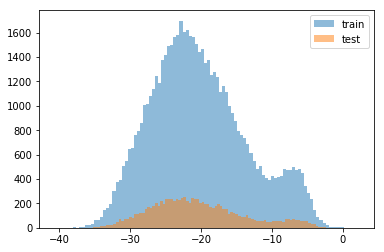

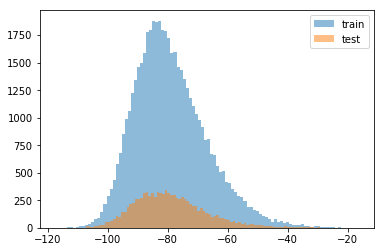

In [19]:
# ***** MNIST and CIFAR train/test histograms
# Visualize real mnist pixel predictions for mnist with ones
mnistTrain = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTrainPixel.mat')
mnistTest = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTestPixel.mat')
cifarTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainPixel.mat')
cifarTest = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTestPixel.mat')

# mnistRealTrain = getLoaders('mnist', datasetOnly=True, mode='train')
# mnistRealTest = getLoaders('mnist', datasetOnly=True, mode='test')
# cifarRealTrain = getLoaders('cifar10', datasetOnly=True, mode='train')
# cifarRealTest = getLoaders('cifar10', datasetOnly=True, mode='test')

histogramOverlap(mnistTrain['probs'], mnistTest['probs'], savePrefix='allPlotsFinal/final/mnist_hist_train_test')
histogramOverlap(cifarTrain['probs'], cifarTest['probs'], savePrefix='allPlotsFinal/final/cifar_hist_train_test')

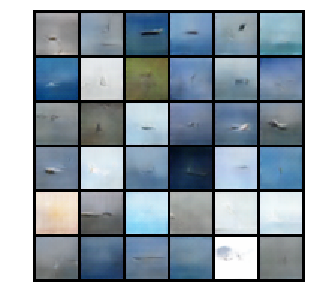

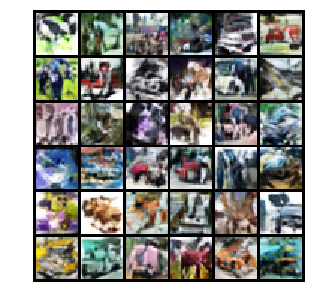

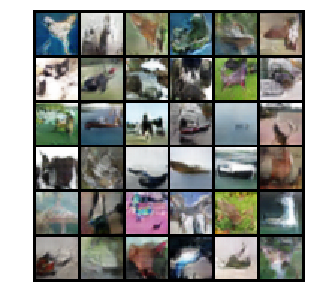

In [17]:
# *** Visualize top/bottom of each image type for Cifar ***
cifarSample = loadmat('/fs/vulcan-scratch/krusinga/projects/ganProbability/generated/e46/data/samples.mat')
#mnistInfoSample = loadmat('/fs/vulcan-scratch/krusinga/projects/ganProbability/generated/final/infogan/mnist/standard/numerical_samples/samples.mat')
#mnistTest = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTestPixel.mat')
#cifarSample = loadmat('generated/final/infogan/mnist/standard/data_samples/cifarTrainPixel.mat')
#cifarTest = loadmat('generated/final/infogan/mnist/standard/data_samples/cifarTestPixel.mat')
p = cifarSample['prob'].squeeze()
ims = cifarSample['images']
cifarSampleDict = {'probs':p, 'images':ims}

hiLow(cifarSampleDict, number=36, imageArray=None, nrow=6, resolution=5, classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/cifar_sample')

Making dir


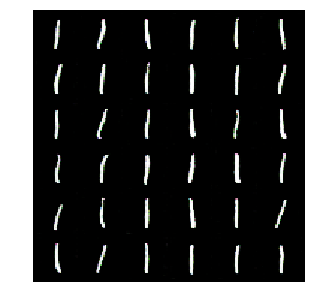

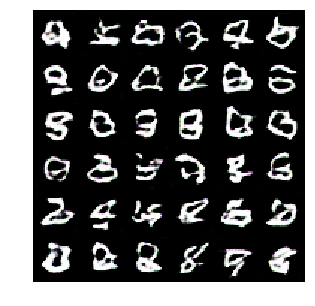

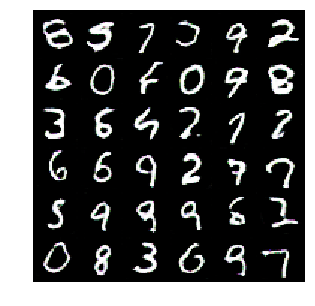

In [20]:
# *** Visualize top/bottom of each image type for MNIST ***
mnistSample = loadmat('/fs/vulcan-scratch/krusinga/projects/ganProbability/generated/e47/data/samples.mat')
#mnistInfoSample = loadmat('/fs/vulcan-scratch/krusinga/projects/ganProbability/generated/final/infogan/mnist/standard/numerical_samples/samples.mat')
#mnistTest = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTestPixel.mat')
#cifarSample = loadmat('generated/final/infogan/mnist/standard/data_samples/cifarTrainPixel.mat')
#cifarTest = loadmat('generated/final/infogan/mnist/standard/data_samples/cifarTestPixel.mat')
p = mnistSample['prob'].squeeze()
ims = mnistSample['images']
mnistSampleDict = {'probs':p, 'images':ims}

hiLow(mnistSampleDict, number=36, imageArray=None, nrow=6, resolution=5, classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/mnist_sample')

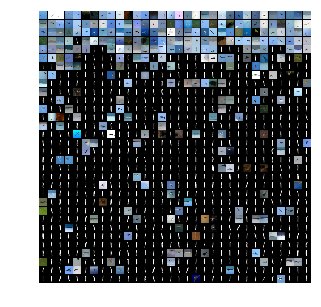

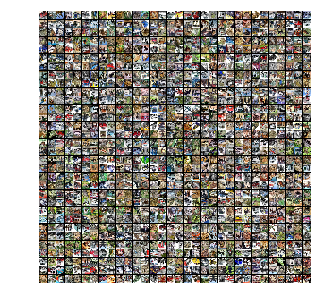

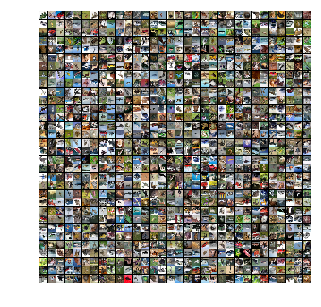

In [51]:
# ******* Be careful what you wish for
# ***** MNIST and CIFAR train together
# Visualize real mnist pixel predictions for mnist with ones
#mnistTrain = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTrainPixel.mat')
#mnistTest = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTestPixel.mat')
cifarTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainPixel.mat')
mnistTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/mnistTrainPixel.mat')


mnistRealTrain = getLoaders('mnist', datasetOnly=True, mode='train')
# mnistRealTest = getLoaders('mnist', datasetOnly=True, mode='test')
cifarRealTrain = getLoaders('cifar10', datasetOnly=True, mode='train')
# cifarRealTest = getLoaders('cifar10', datasetOnly=True, mode='test')

mnistRealTrain.X = np.concatenate([mnistRealTrain.X]*3, 1)


imsTogether = np.concatenate((cifarRealTrain.X, mnistRealTrain.X))

altogether = np.concatenate((cifarTrain['probs'].squeeze(), mnistTrain['probs'].squeeze()))
hiLowFlip({'images':imsTogether, 'probs':altogether}, number=1024, imageArray=None, nrow=32, resolution=5, 
      classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/cifar_train_and_mnist')

In [ ]:
# Visualize real mnist pixel predictions for mnist with ones
#mnistTrain = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTrainPixel.mat')
#mnistTest = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTestPixel.mat')
cifarTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainPixel.mat')
mnistTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/mnistTrainPixel.mat')


mnistRealTrain = getLoaders('mnist', datasetOnly=True, mode='train')
# mnistRealTest = getLoaders('mnist', datasetOnly=True, mode='test')
cifarRealTrain = getLoaders('cifar10', datasetOnly=True, mode='train')
# cifarRealTest = getLoaders('cifar10', datasetOnly=True, mode='test')

mnistRealTrain.X = np.concatenate([mnistRealTrain.X]*3, 1)


imsTogether = np.concatenate((cifarRealTrain.X, mnistRealTrain.X))

altogether = np.concatenate((cifarTrain['probs'].squeeze(), mnistTrain['probs'].squeeze()))
hiLowFlip({'images':imsTogether, 'probs':altogether}, number=1024, imageArray=None, nrow=32, resolution=5, 
      classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/cifar_train_and_mnist')

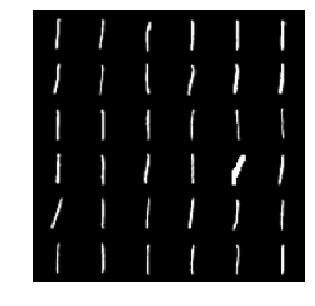

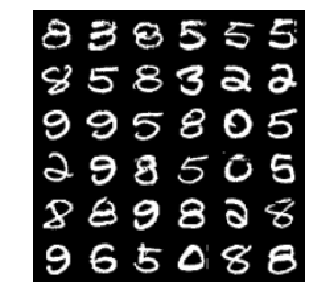

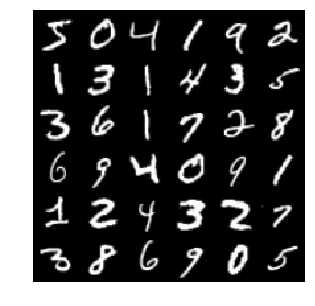

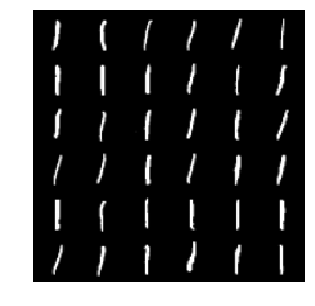

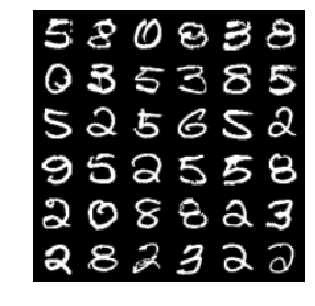

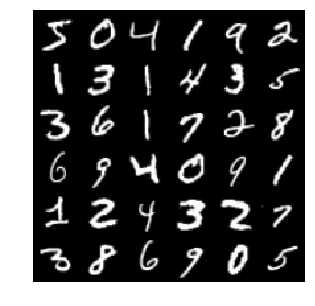

In [47]:
# MNIST, MNIST-1

mnistTrain = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTrainPixel.mat')
mnistNoOnesTrain = loadmat('generated/final/infogan/mnist/no_ones/data_samples/mnistTrainPixel.mat')
#cifarTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainPixel.mat')
#cifarTest = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTestPixel.mat')

pOnes = mnistTrain['probs'].squeeze()
pNoOnes = mnistNoOnesTrain['probs'].squeeze()


mnistRealTrain = getLoaders('mnist', datasetOnly=True, mode='train')
# mnistRealTest = getLoaders('mnist', datasetOnly=True, mode='test')
#cifarRealTrain = getLoaders('cifar10', datasetOnly=True, mode='train')
# cifarRealTest = getLoaders('cifar10', datasetOnly=True, mode='test')
hiLow({'images':mnistRealTrain.X, 'probs':pOnes}, number=36, imageArray=None, nrow=6, resolution=5, 
      classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/mnist_real_ones')
hiLow({'images':mnistRealTrain.X, 'probs':pNoOnes}, number=36, imageArray=None, nrow=6, resolution=5, 
      classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/mnist_real_no_ones')

Making dir
Class 0
Class 1
Class 2
Class 3
Class 4
Class 5
Class 6
Class 7
Class 8
Class 9


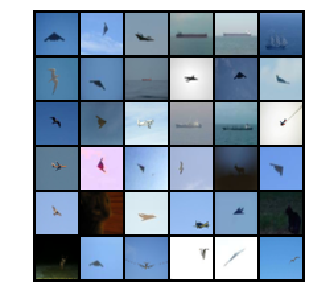

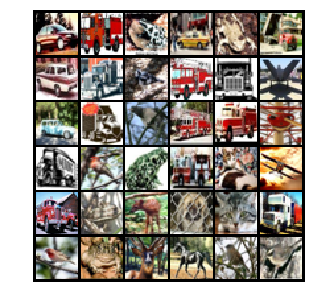

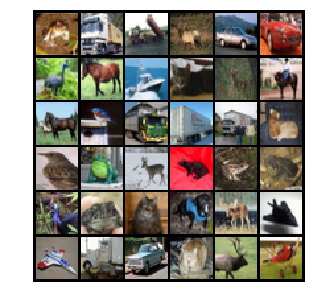

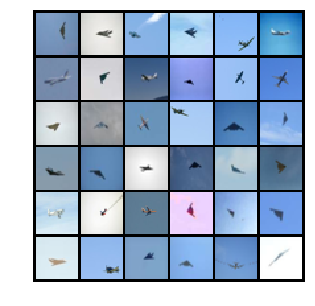

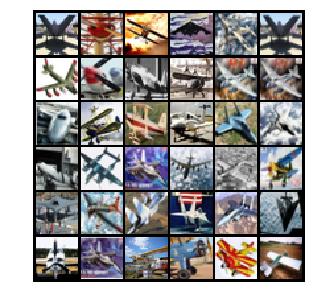

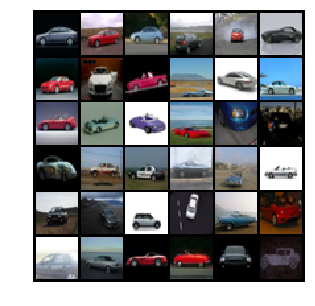

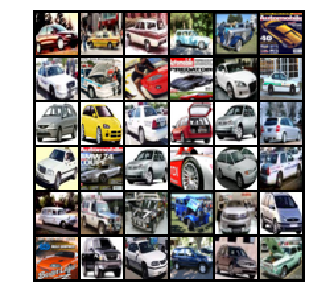

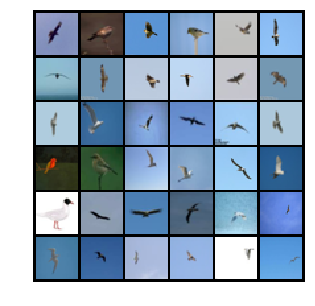

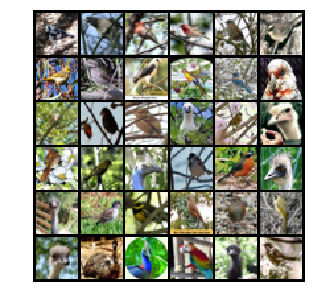

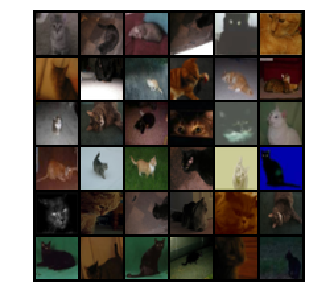

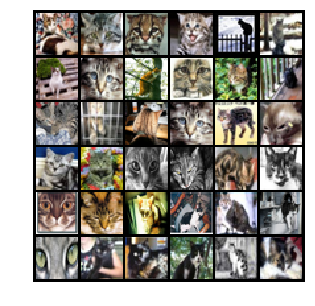

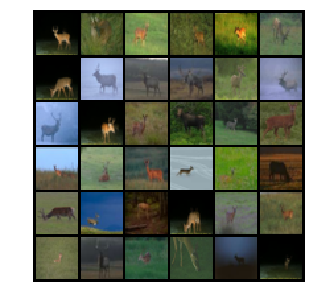

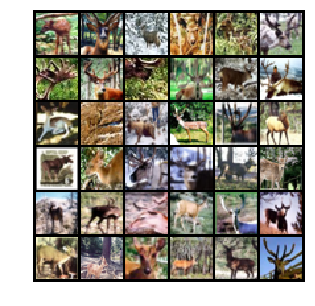

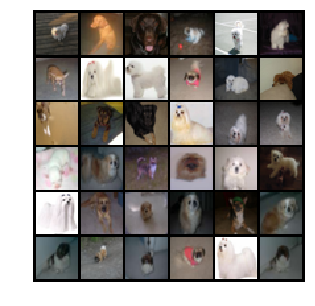

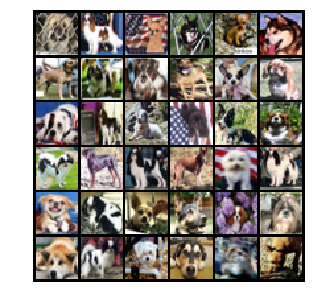

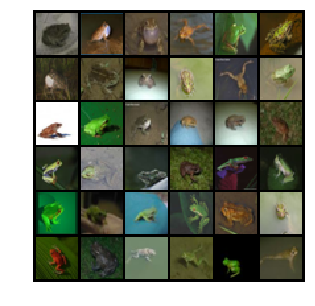

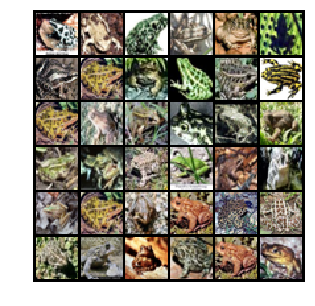

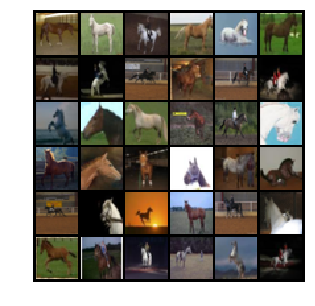

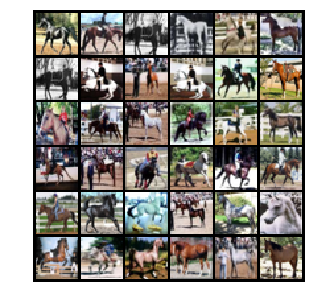

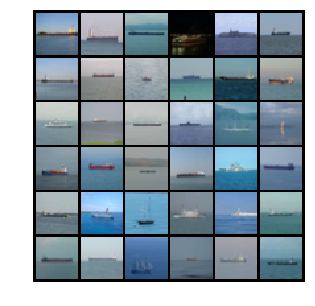

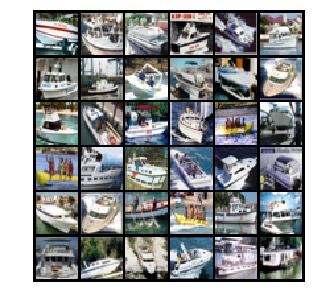

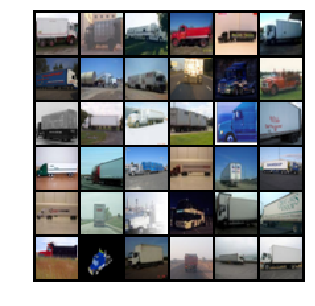

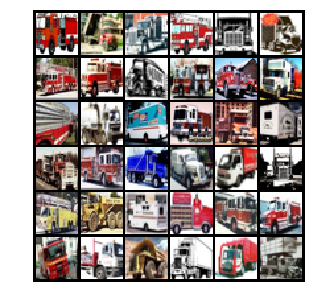

In [48]:
#mnistTrain = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTrainPixel.mat')
#mnistNoOnesTrain = loadmat('generated/final/infogan/mnist/no_ones/data_samples/mnistTrainPixel.mat')
cifarTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainPixel.mat')
#cifarTest = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTestPixel.mat')

#pOnes = mnistTrain['probs'].squeeze()
#pNoOnes = mnistNoOnesTrain['probs'].squeeze()


#mnistRealTrain = getLoaders('mnist', datasetOnly=True, mode='train')
# mnistRealTest = getLoaders('mnist', datasetOnly=True, mode='test')
cifarRealTrain = getLoaders('cifar10', datasetOnly=True, mode='train')
# cifarRealTest = getLoaders('cifar10', datasetOnly=True, mode='test')
Y = cifarRealTrain.Y.squeeze()

p = cifarTrain['probs'].squeeze()

hiLow({'images':cifarRealTrain.X, 'probs':p}, number=36, imageArray=None, nrow=6, resolution=5, 
      classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/cifar_real')
hiLow({'images':cifarRealTrain.X, 'probs':p}, number=36, imageArray=None, nrow=6, resolution=5, 
      classes=Y, useCodeProbs=False, savePrefix='allPlotsFinal/final/cifar_real')

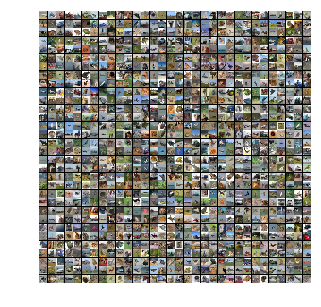

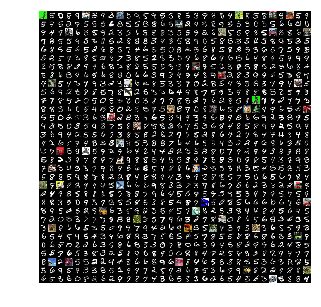

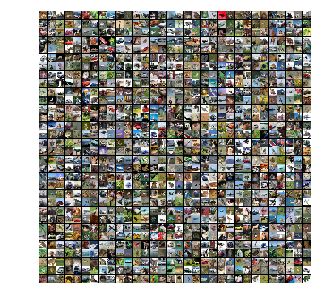

In [4]:
##### Onward to Z values
# ******* Be careful what you wish for
# ***** MNIST and CIFAR train together, CODES
# Visualize real mnist pixel predictions for mnist with ones
#mnistTrain = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTrainPixel.mat')
#mnistTest = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTestPixel.mat')
cifarTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainCode.mat')
mnistTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/mnistTrainCode.mat')


mnistRealTrain = getLoaders('mnist', datasetOnly=True, mode='train')
# mnistRealTest = getLoaders('mnist', datasetOnly=True, mode='test')
cifarRealTrain = getLoaders('cifar10', datasetOnly=True, mode='train')
# cifarRealTest = getLoaders('cifar10', datasetOnly=True, mode='test')

mnistRealTrain.X = np.concatenate([mnistRealTrain.X]*3, 1)


imsTogether = np.concatenate((cifarRealTrain.X, mnistRealTrain.X))

altogether = np.concatenate((cifarTrain['probs'].squeeze(), mnistTrain['probs'].squeeze()))
hiLow({'images':imsTogether, 'probs':altogether}, number=1024, imageArray=None, nrow=32, resolution=5, 
      classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/cifar_train_and_mnist_codes')

Making dir
Making dir


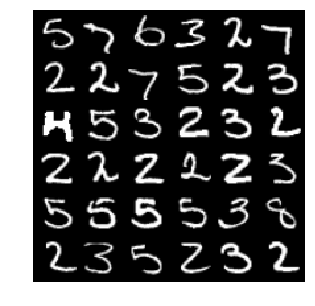

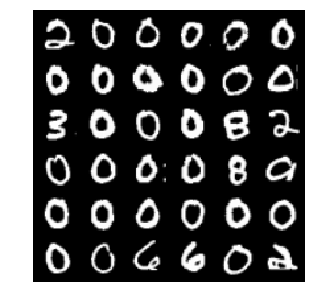

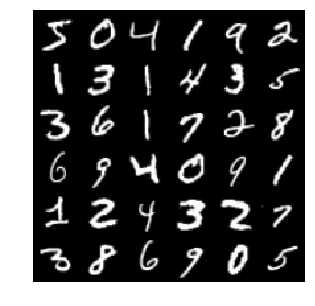

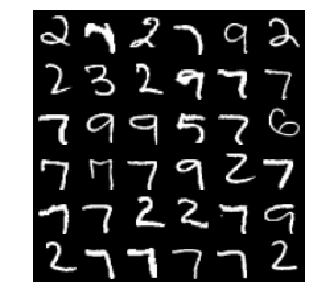

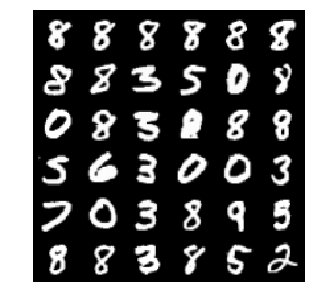

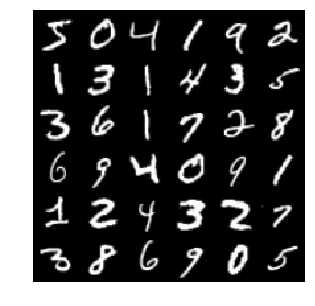

In [53]:
# MNIST, MNIST-1

mnistTrain = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTrainCode.mat')
mnistNoOnesTrain = loadmat('generated/final/infogan/mnist/no_ones/data_samples/mnistTrainCode.mat')
#cifarTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainPixel.mat')
#cifarTest = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTestPixel.mat')

pOnes = mnistTrain['probs'].squeeze()
pNoOnes = mnistNoOnesTrain['probs'].squeeze()


mnistRealTrain = getLoaders('mnist', datasetOnly=True, mode='train')
# mnistRealTest = getLoaders('mnist', datasetOnly=True, mode='test')
#cifarRealTrain = getLoaders('cifar10', datasetOnly=True, mode='train')
# cifarRealTest = getLoaders('cifar10', datasetOnly=True, mode='test')
hiLow({'images':mnistRealTrain.X, 'probs':pOnes}, number=36, imageArray=None, nrow=6, resolution=5, 
      classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/mnist_real_ones_codes')
hiLow({'images':mnistRealTrain.X, 'probs':pNoOnes}, number=36, imageArray=None, nrow=6, resolution=5, 
      classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/mnist_real_no_ones_codes')

Making dir
Class 0
Class 1
Class 2
Class 3
Class 4
Class 5
Class 6
Class 7
Class 8
Class 9


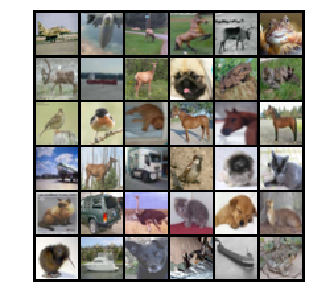

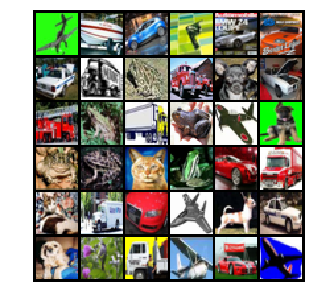

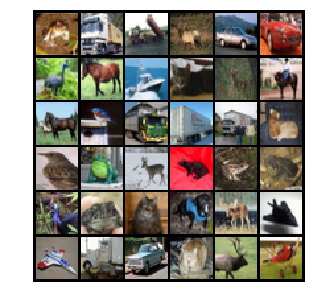

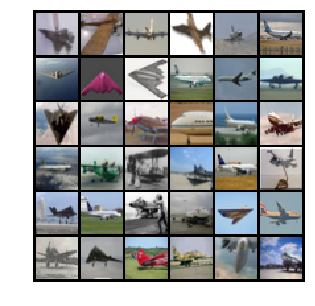

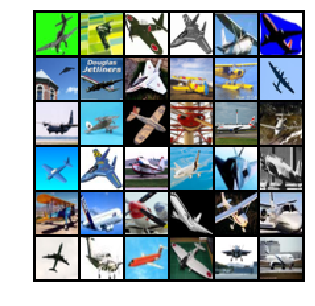

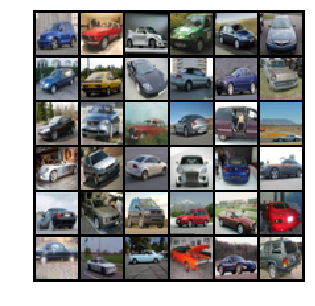

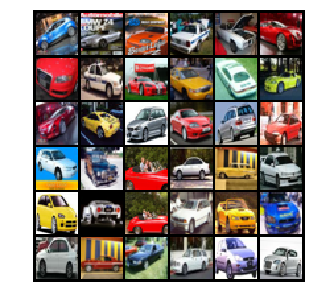

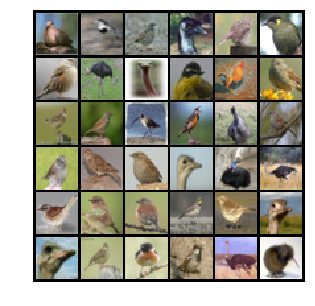

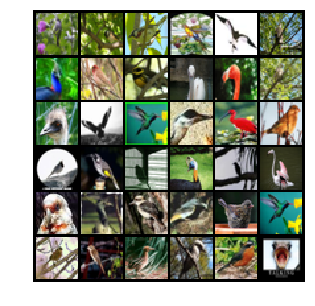

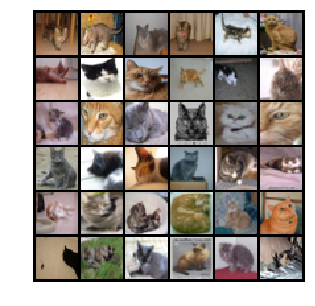

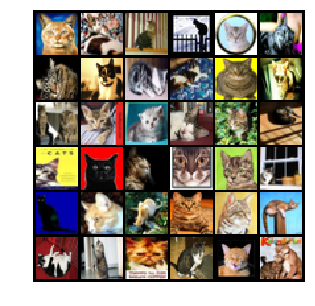

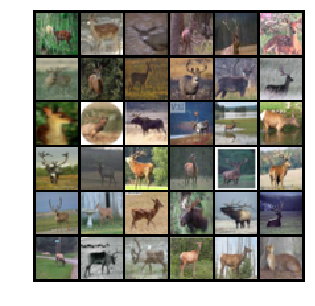

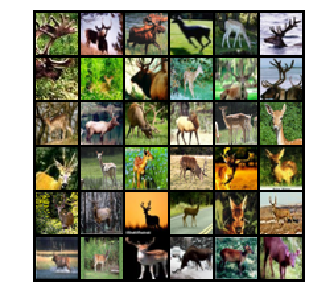

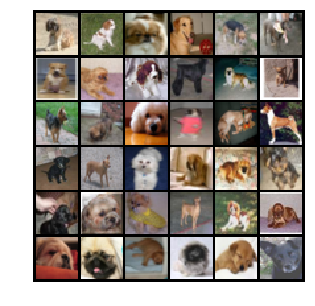

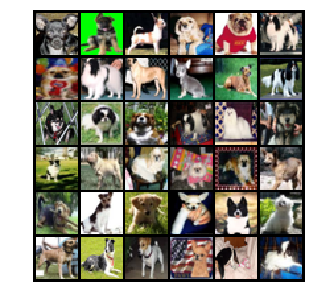

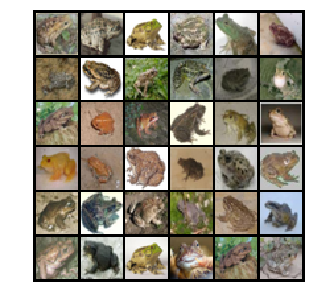

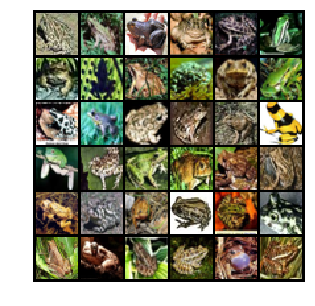

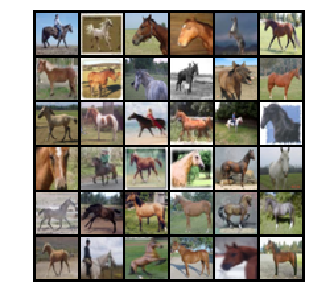

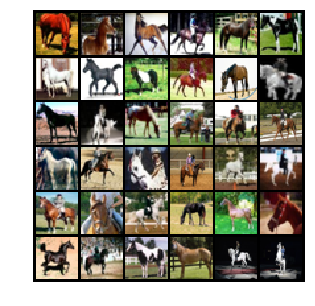

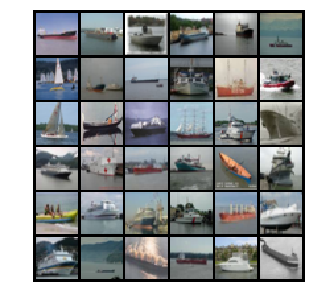

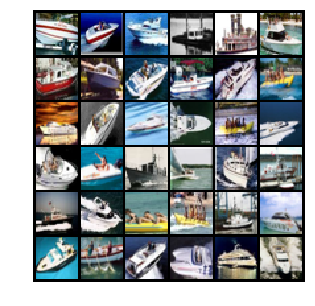

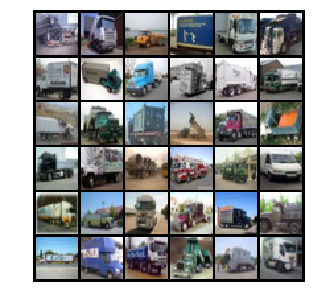

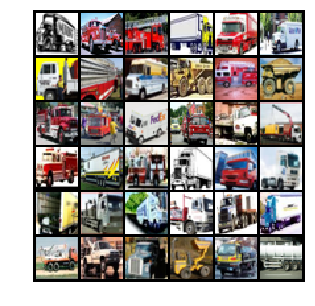

In [54]:
#mnistTrain = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTrainPixel.mat')
#mnistNoOnesTrain = loadmat('generated/final/infogan/mnist/no_ones/data_samples/mnistTrainPixel.mat')
cifarTrain = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainCode.mat')
#cifarTest = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTestPixel.mat')

#pOnes = mnistTrain['probs'].squeeze()
#pNoOnes = mnistNoOnesTrain['probs'].squeeze()


#mnistRealTrain = getLoaders('mnist', datasetOnly=True, mode='train')
# mnistRealTest = getLoaders('mnist', datasetOnly=True, mode='test')
cifarRealTrain = getLoaders('cifar10', datasetOnly=True, mode='train')
# cifarRealTest = getLoaders('cifar10', datasetOnly=True, mode='test')
Y = cifarRealTrain.Y.squeeze()

p = cifarTrain['probs'].squeeze()

hiLow({'images':cifarRealTrain.X, 'probs':p}, number=36, imageArray=None, nrow=6, resolution=5, 
      classes=None, useCodeProbs=False, savePrefix='allPlotsFinal/final/cifar_real_codes')
hiLow({'images':cifarRealTrain.X, 'probs':p}, number=36, imageArray=None, nrow=6, resolution=5, 
      classes=Y, useCodeProbs=False, savePrefix='allPlotsFinal/final/cifar_real_codes')